# Phase Prediction of 2D Rydberg Atom Systems with Conditional Generative Models
Haoxiang Wang (hwang264@illinois.edu)

Work done as an applied scientist intern at Amazon Braket in 2022

In [1]:
import sys
# to read modules from the parent directory
sys.path.insert(0,'..')

In [2]:
import numpy as np
import pickle
from time import time
from joblib import Parallel, delayed
from src.models.mlp import MLP
from src.eval import RydbergEvaluator
from src.eval.eval_rydberg import est_density_from_z_measurements,determine_phase_1D,determine_phase_2D,est_order_param_1D,phase2img,est_phase_diagram,est_order_param_1D_fourier_from_measurements,est_order_param_1D_fourier,fourier_transform_square_lattice,est_order_param_2D_from_measurements
from src.data.loading.dataset_rydberg import RydbergDataset,unif_sample_on_grid
# Transformer
import argparse
from constants import *
from src.training.rydberg_trainers import RydbergConditionalTransformerTrainer
from src.models.transformer import init_conditional_transformer
from src.models.mlp import MLP


import torch
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm,trange
import os

from src.utils import plot_phase_diagram
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Rydberg Hamiltonian
This example is about trapped Rydberg atoms, a class of highly controllable neural atoms that can be used to build programmable Ising-type quantum simulators \cite{Rydberg-spin-liquids,Rydberg1D-51atoms,Rydberg2D-256atoms}. In Ising-type quantum simulations, a Rydberg atom is effectively considered as a two-level system consisting of a ground state $| g \rangle$ (i.e., $|0\rangle$) and a highly-excited state $ | r\rangle$ (i.e., $|1 \rangle$) called Rydberg state. Rydberg atoms can be allocated on a plane and trapped by light tweezers. In \cite{Rydberg1D-51atoms}, Rydberg atoms are placed along a 1D lattice (i.e., a chain) equidistantly, while \cite{Rydberg2D-256atoms} allocates the atoms as a 2D square lattice. For either a 1D or 2D lattice of Rydberg atoms, denoting the nearest-neighbor distance of atoms $a$, the Hamiltonian of such a system can be described by
\begin{align}\label{eq:H-rydberg}
    H=\frac{\Omega}{2} \sum_{i} X_{i}-\Delta \sum_{i} N_{i}+\sum_{i<j}\left(\frac{V_{0}}{|\vec x_i- \vec x_j|}\right)^{6} N_{i} N_{j} ~,
\end{align}
where $\Omega$ is the Rabi frequency, $\Delta$ is the detuning of laser, $R_b$ is a constant, $\vec x_i$ is the location vector of the qubit $i$, and $N_i$ is the occupation number operator at site $i$, i.e., $N_i = |{r_i}\rangle \langle {r_i} |$


## Approximate Ground States via Adiabatic Evolution

The many-body ground state of a Rydberg Hamiltonian is typically obtained via \textit{adiabatic evolution}. 
Initially, each Rydberg atom is prepared in its ground state $|0\rangle$ (with high precision) such that the many-body state is $|0\dots 0\rangle$, which is the ground state of the Rydberg Hamiltonian with a large negative detuning $\Delta$ and zero-valued $\Omega$. Then, the detuning strength $\Delta$ is ramped up gradually to positive values, while the Rabi frequency is turned on (i.e., $\Omega > 0$). Clearly, the Hamiltonian of the Rydberg system is time-dependent according to a custom scheduler for $\Delta$ and $\Omega$. By the Adiabatic Theorem of quantum mechanics, we know as the time evolution process is slow enough, the quantum state of the system always stays closes to the ground state of the time-dependent Hamiltonian at any time step. Therefore, as the evolution process is sufficiently slow, we can end up with a prepared state that is approximately the ground state of the final Hamiltonian. 

## Load Simulation Results of Adiabatic Evolution

We conducted classical simulations for the adiabatic evolution of 2D Rydberg systems using [Bloqade.jl](https://github.com/QuEraComputing/Bloqade.jl/). The code for the simulation is presented in `rydberg/`.

Below, we load simulation data stored in `data/rydberg`.
+ For each simulation run of adiabatic evolution, we initiate a Rydberg lattice with a custom atom separation (i.e., $a$ in the Hamiltonian), and tune $\Delta, \Omega$ according to a preset scheduler. We take multiple time steps across the evolution, performing meausurements in the Z-basis, and save the measurement data locally.


### Scheduler for $\Delta, \Omega$
Here we show the schedulers we use for the adiabatic evolution simulation.

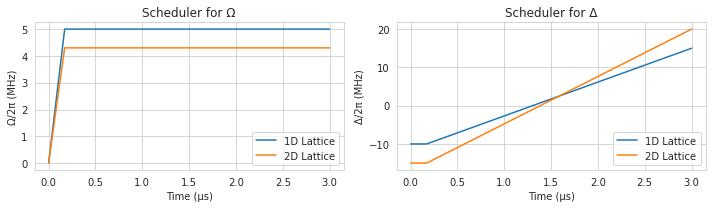

In [3]:
# Here we define a base schedule -- 
sns.set_style('whitegrid')
base_time = 3.5
ts = np.array([0,0.2,base_time])
omegas_2 = np.array([0, 4.3, 4.3])
deltas_2 = np.array([-15, -15, 20])

omegas_1 = np.array([0, 5, 5])
deltas_1 = np.array([-10, -10, 15])

total_time = 3 # Total adiabatic evolution time of the Bloqade simulation
# We propotionally lengthen the schedules for Omega and Delta by time_ratio = total_time/base_time
time_ratio = total_time/base_time


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 3))
ax1.plot(ts*time_ratio, omegas_1,label='1D Lattice')
ax1.plot(ts*time_ratio, omegas_2,label='2D Lattice')
ax1.set_ylabel("Ω/2π (MHz)")
ax1.set_xlabel("Time (μs)")
ax1.set_title("Scheduler for Ω")
ax1.legend(loc='lower right')
ax2.plot(ts*time_ratio, deltas_1,label='1D Lattice')
ax2.plot(ts*time_ratio, deltas_2,label='2D Lattice')
ax2.legend(loc='lower right')
ax2.set_ylabel("Δ/2π (MHz)")
ax2.set_xlabel("Time (μs)")
ax2.set_title("Scheduler for Δ")
fig.tight_layout()

Now we load simulated data.

## Phase Diagram of Rydberg Lattice



In [4]:
nx,ny=5,5
n_qubits = nx*ny 
dim = 2
total_time = 3
root = '../'
folder = root+ f'data/rydberg/2D-Phase_{nx}x{ny}/{float(np.round(total_time,2))}µs/'

In [5]:
meta_dataset = RydbergDataset(dim=dim,nx = nx, ny=ny, folder=folder,n_threads=20, var_name='interaction_range',) 

In [6]:
order_params = ['Checkboard','Striated','Staggered']
n_gen_samples = 1000
base_kwargs = {'nx':nx, 
              'ny':ny}
xlabel = 'detuning'
ylabel = 'interaction_range'
phases_gen ={} 
phases_true={}

In [7]:
meta_dataset.est_order_params(order_params=order_params,est_from_measurements=True)
df = meta_dataset.info.copy()

In [8]:
threshold = 0.65
df['phase'] = determine_phase_2D(df,order_params,threshold=threshold)

In [9]:
hue_order = ['Disordered']+order_params

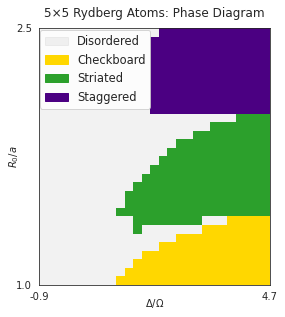

In [10]:
sns.set_style('white')
plot_df = df.copy()
plot_df = plot_df.iloc[np.isin(plot_df['interaction_range'].values, np.unique(plot_df['interaction_range'].unique())[::2])]
plot_df = plot_df.loc[(plot_df['detuning'] >=-1) & (plot_df['interaction_range'] > 1)]
fig = plot_phase_diagram(plot_df,title=f"{nx}×{ny} Rydberg Atoms: Phase Diagram",
                         hue_order =hue_order, legend=True)

## Prepare Training Set

We split the phase diagram by grids (defined by `x_bins` and `y_bins`), and sample one point in each grid for training. Each point represents the ground state of one quantum system with the corresponding variables ($a,\Delta,\Omega$).

In [11]:

def prepare_train_set(meta_dataset, df=None, n_measurements:int = -1, x_bins=10,y_bins=10):
    train_set = {}
    if df is None: df = meta_dataset.info
    train_idxes, train_df = unif_sample_on_grid(df.copy(),x_bins=x_bins,y_bins=y_bins)#,x_range=(0.4,1.78),y_range=(1.4,2.4))
    # train_idxes = plot_df.index.values
    train_keys = meta_dataset.keys[train_idxes]
    train_set.update(meta_dataset.prepare_train_set(train_keys,n_measurements=n_measurements))
    return train_set, train_idxes
    

In [12]:
load_pretrained = True

In [13]:
if load_pretrained:
    train_idxes = np.load(root + 'logs/rydberg_2D/train_idxes.npy')
    train_set = pickle.load( open(root + 'logs/rydberg_2D/train_set.pkl','rb'))
    # np.save('logs/rydberg_2D/train_idxes.npy',train_idxes)
    # pickle.dump(train_set, open('logs/rydberg_2D/train_set.pkl','wb'))
    # pickle.dump(meta_dataset, open('logs/rydberg_2D/meta_dataset.pkl','wb'))
else: 
    train_set, train_idxes = prepare_train_set(meta_dataset,df=plot_df)
    # meta_dataset = pickle.load(open('logs/rydberg_2D/meta_dataset.pkl','rb'))

+ The darker points are the sysmtems used for training.

In [14]:
hue_order = ['Disordered']+order_params

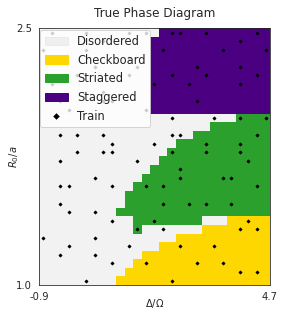

In [15]:
fig_true = plot_phase_diagram(plot_df,title=f"True Phase Diagram",train_idxes=train_idxes,
                              hue_order = hue_order, legend=True)

In [16]:
len(plot_df)

810

## Train a Conditional Generative Model

We first define some hyperparameters as follows

In [17]:
def parse_args(args=[]):
    parser = argparse.ArgumentParser()
    parser.add_argument('--dim',type=int,default=1)
    parser.add_argument('--nx',type=int,default=19)
    parser.add_argument('--ny',type=int,default=1)
    parser.add_argument('--total_time',type=float,default=6)
    parser.add_argument('--results-dir', type=str, default='results-debug')
    parser.add_argument('--tf-arch', type=str, default='transformer_l4_d128_h4')
    parser.add_argument('--reps', type=int, default=1)
    parser.add_argument('--ns', type=int, default=800, help='number of samples per hamiltonian')
    parser.add_argument('--iterations', type=int, default=50000, help="training iterations")
    parser.add_argument('--eval-every', type=int, default=100)
    parser.add_argument('--eval-samples', type=int, default=10000, help='number of generated samples for evaluation')
    parser.add_argument('--k', type=int, default=1, help='number of buckets for median of means estimation')
    parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
    parser.add_argument('--verbose', type=int, default=1, choices=[0, 1])
    parser.add_argument('--epoch-mode', type=int, default=1, choices=[0, 1])
    parser.add_argument('--condition-mode', type=int, default=0, choices=[0, 1])
    parser.add_argument('--seed', type=int, default=None)
    return parser.parse_args(args)


def get_hyperparams(**kwargs):
    hparams = argparse.Namespace(
        lr=1e-3,
        wd=0,
        bs=512,
        dropout=0.0,
        lr_scheduler=WARMUP_COSINE_SCHEDULER,
        warmup_frac=0.,
        final_lr=1e-7,
        smoothing=0.0,
        use_padding=0,
        val_frac=0.25,
        cattn=0
    )

    for k, v in kwargs.items():
        setattr(hparams, k, v)

    return hparams
args = parse_args()
hparams = get_hyperparams()

In [18]:
num_outcomes = 2 # for rydberg systems

n_vars = len(list(train_set.keys())[0])
gpu_idx = 1
device = torch.device(f"cuda:{gpu_idx}")

rng = np.random.default_rng(seed=args.seed)
# setup transformer
d_model = TF_ARCHS[args.tf_arch]['d_model']
n_head = TF_ARCHS[args.tf_arch]['n_head']
n_layers = TF_ARCHS[args.tf_arch]['n_layers']
assert d_model % n_head == 0, 'd_model must be integer multiple of n_head!'

We construct a MLP (fully-connected net) as the encoder and a transformer as the generative model, and then train the model

In [19]:
encoder = MLP(input_size=n_vars, output_size=d_model, 
              n_layers=1, hidden_size=128, activation='ELU', 
              input_layer_norm=False,
              output_batch_size=None, device=device,
             output_factor=1.)

transformer = init_conditional_transformer(
        n_outcomes=num_outcomes,
        encoder=encoder,
        n_layers=n_layers,
        d_model=d_model,
        d_ff=4 * d_model,
        n_heads=n_head,
        dropout=hparams.dropout,
        version=hparams.use_padding,
        use_prompt=False, #***
)

trainer = RydbergConditionalTransformerTrainer(model=transformer,
                                  train_dataset=train_set,
                                  test_dataset=None,
                                  iterations=args.iterations,
                                  lr=hparams.lr,
                                  final_lr=hparams.final_lr,
                                  lr_scheduler=hparams.lr_scheduler,
                                  warmup_frac=hparams.warmup_frac,
                                  weight_decay=hparams.wd,
                                  batch_size=hparams.bs,
                                  rng=rng,
                                  smoothing=hparams.smoothing,
                                  eval_every=args.eval_every,
                                  transfomer_version=hparams.use_padding,
                                  device=device)
model_name = f'transformer_nq{nx}x{ny}_iter-{args.iterations//1000}k'

In [20]:

if load_pretrained:
    ckpt_path = root + f'logs/rydberg_2D/{model_name}.pth'
    transformer = torch.load(ckpt_path)
    transformer.to(device)
    transformer.device = device
    print(f'Loaded trained model from {ckpt_path}')
else:
    trainer.train()
    torch.save(transformer,root + f'logs/rydberg_2D/{model_name}.pth') # You can save the trained model

Loaded trained model from ../logs/rydberg_2D/transformer_nq5x5_iter-50k.pth


For every point in the phase diagram, we use the conditional generative model to generate `n_gen_samples` measurements, and then determine the phase by order parameters.

In [21]:
torch.manual_seed(0) # Set seed to ensure reproduction
torch.cuda.manual_seed(0)
n_gen_samples = 1000
test_df = plot_df.copy()
test_df[order_params] = np.nan
densities = {}
transformer.eval()
n_qubits = nx*ny
for idx in tqdm(test_df.index,"Generation"):
    key = meta_dataset.keys[idx]
    condition = torch.from_numpy(np.array([key])).float()
    gen_samples = transformer.sample_batch(cond_var=condition,batch_size=n_gen_samples,
                                               num_qubits=n_qubits)
    density = gen_samples.mean(axis=0)
    densities[idx] = density
    for order_param in order_params:
        test_df.loc[idx, order_param] = est_order_param_2D_from_measurements(gen_samples,order_param=order_param,
                                                                             nx=nx,ny=ny)

Generation:   0%|          | 0/810 [00:00<?, ?it/s]

In [22]:
test_df['phase'] = determine_phase_2D(test_df,order_params,threshold=threshold)

Now we can compare the phase diagram predicted by our trained model against the ground truth phase diagram.

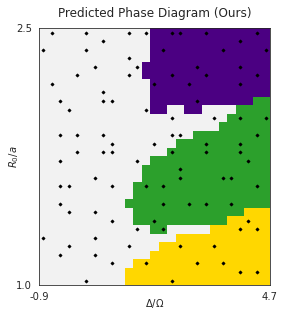

In [23]:
fig_pred = plot_phase_diagram(test_df,title=f"Predicted Phase Diagram (Ours)",
                              train_idxes=train_idxes,hue_order=hue_order,)

In [24]:
test_idxes = np.sort(plot_df.index[~np.isin(plot_df.index,train_idxes)])

In [25]:
pred_order_params = test_df.loc[test_idxes][order_params].values
true_order_params = meta_dataset.info.loc[test_idxes][order_params].values 
err_CGM = np.sqrt(np.mean((pred_order_params - true_order_params)**2))
err_CGM

0.07085891750039128

In [26]:
def compute_acc(pred_df,true_df,idxes=None):
    if idxes is not None:
        pred_df = pred_df.loc[idxes]
        true_df = true_df.loc[idxes]
    V = pred_df['phase'].values == true_df['phase'].values
    clf_acc = np.mean(V)
    return clf_acc

In [27]:
compute_acc(test_df,plot_df,test_idxes)

0.9549295774647887

In [28]:
from src.models.kernels import build_dirichlet_kernel,build_NTK
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer

In [29]:
train_keys = list(train_set.keys())
base_kwargs = dict(nx=nx, ny=ny)
Xs,Xs_test,Ys,Ys_test = [],[],[],[]
for key, measurements in train_set.items():
    x = np.array(key)
    density = np.mean(measurements,axis=0)
    y = [est_order_param_2D_from_measurements(measurements,order_param=order_param,**base_kwargs) for order_param in order_params]
    # y = density
    Xs.append(x)
    Ys.append(y)
Xs,Ys = np.array(Xs),np.array(Ys)

scaler = MinMaxScaler()#Normalizer()
# scaler = StandardScaler()
Xs = scaler.fit_transform(Xs)
Xs_test = scaler.transform(meta_dataset.keys[test_idxes])
Ys_test = meta_dataset.info.loc[test_idxes][order_params].values

+ Dirichlet Kernel

In [30]:
train_dirichlet_kernel = build_dirichlet_kernel(Xs)
test_dirichlet_kernel = build_dirichlet_kernel(Xs_test)

In [31]:
C_dir = 1e5
clf_dir = KernelRidge(kernel='linear',alpha=1/(2*C_dir)).fit(train_dirichlet_kernel,Ys)

In [32]:
pred_dirichlet = clf_dir.predict(test_dirichlet_kernel)
err_dirichlet = np.sqrt(np.mean((pred_dirichlet - Ys_test)**2))

In [33]:
# Error (RMSE)
err_dirichlet

0.17912040912155988

+ Gaussian Kernel (i.e., RBF Kernel)

In [34]:
C_rbf = 1e9
clf_rbf = KernelRidge(kernel='rbf',alpha=1/(2*C_rbf)).fit(Xs,Ys)
pred_rbf = clf_rbf.predict(Xs_test)
err_rbf = np.sqrt(np.mean((pred_rbf - Ys_test)**2))

In [35]:
err_rbf

0.11916088090677637

+ Neural Tangent Kernel (NTK)

In [36]:
# We found the GPU version of Jax doesn't give stable NTK results when the regularization is very small, 
# i.e., the coefficient C is large.
# So we let Jax to run on CPU only when computing the NTK
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [37]:
C_ntk = 50
NTK, ntk_pred_fn = build_NTK(Xs,Ys,C=C_ntk,layers=50,normalize=False,activation='Erf')
pred_ntk = ntk_pred_fn(Xs_test)
err_ntk = np.sqrt(np.mean((pred_ntk - Ys_test)**2))

In [38]:
err_ntk

0.09654722114579631

In [39]:
df = plot_df.copy()
for order_param in order_params:
    df[order_param] = np.nan
keys = meta_dataset.keys[df.index.values]
xs = scaler.transform(keys)

df[order_params] = clf_rbf.predict(xs)
df['phase'] = determine_phase_2D(df,order_params,threshold)
df = df.sort_values(['phase'])
df_rbf = df.copy()

df = plot_df.copy()
df[order_params] = clf_dir.predict(build_dirichlet_kernel(xs))
df['phase'] = determine_phase_2D(df,order_params,threshold)
df = df.sort_values(['phase'])
df_dir = df.copy()

df = plot_df.copy()
df[order_params] = ntk_pred_fn(xs)
df['phase'] = determine_phase_2D(df,order_params,threshold)
df = df.sort_values(['phase'])
df_ntk = df.copy()

**Classification Accuracy**

In [40]:
print('Dirichlet Kernel: {:.5f}'.format(compute_acc(df_dir, plot_df,test_idxes)))
print('Gaussian Kernel: {:.5f}'.format(compute_acc(df_rbf, plot_df,test_idxes)))
print('NTK: {:.5f}'.format(compute_acc(df_ntk, plot_df,test_idxes)))

Dirichlet Kernel: 0.75775
Gaussian Kernel: 0.89014
NTK: 0.90141


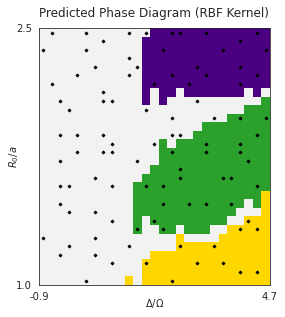

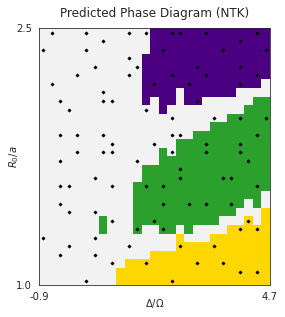

In [41]:
fig_rbf = plot_phase_diagram(df_rbf,title=f"Predicted Phase Diagram (RBF Kernel)",train_idxes=train_idxes,hue_order=hue_order,)
fig_ntk = plot_phase_diagram(df_ntk,title=f"Predicted Phase Diagram (NTK)",train_idxes=train_idxes,hue_order=hue_order,)

In [42]:
# Optional: Save figures locally
fig_pred.tight_layout()
fig_true.tight_layout()
fig_rbf.tight_layout()
fig_ntk.tight_layout()
fig_pred.savefig(root+'figs/paper/2D-phase-ours.pdf')
fig_true.savefig(root+'figs/paper/2D-phase-true.pdf')
fig_rbf.savefig(root+'figs/paper/2D-phase-rbf.pdf')
fig_ntk.savefig(root+'figs/paper/2D-phase-ntk.pdf')